# Toy Dataset Training for Deep3D
- This is an old model using a not persistent model. Cannot dump/restore weights after session is closed. This is not a long term training script, but it is surprisingly our currently best performing model.

In [1]:
import tensorflow as tf
import Deep3D_branched as deep3d
import utils
import numpy as np
import os
import os.path

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Training Loop

In [2]:
batchsize = 50
num_epochs = 8
print_step = 1


left_dir = "/a/data/deep3d_data/frames/train/left/"
right_dir = "/a/data/deep3d_data/frames/train/right/"

with tf.device('/cpu:0'):
    left_image_queue = tf.train.string_input_producer(
      left_dir + tf.convert_to_tensor(os.listdir(left_dir)),
      shuffle=False, num_epochs=num_epochs)
    right_image_queue = tf.train.string_input_producer(
      right_dir + tf.convert_to_tensor(os.listdir(right_dir)),
      shuffle=False, num_epochs=num_epochs)

    # use reader to read file
    image_reader = tf.WholeFileReader()

    _, left_image_raw = image_reader.read(left_image_queue)
    left_image = tf.image.decode_jpeg(left_image_raw)
    left_image = tf.cast(left_image, tf.float32)/255.0

    _, right_image_raw = image_reader.read(right_image_queue)
    right_image = tf.image.decode_jpeg(right_image_raw)
    right_image = tf.cast(right_image, tf.float32)/255.0

    left_image.set_shape([160,288,3])
    right_image.set_shape([160,288,3])

    # preprocess image
    batch = tf.train.shuffle_batch([left_image, right_image], 
                                   batch_size = batchsize,
                                   capacity = 12*batchsize,
                                   num_threads = 1,
                                   min_after_dequeue = 4*batchsize)


# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage
config.allow_soft_placement=True


# Session
sess = tf.Session(config=config)

# Placeholders
images = tf.placeholder(tf.float32, [None, 160, 288, 3], name='input_batch')
true_out = tf.placeholder(tf.float32, [None, 160, 288, 3] , name='ground_truth')
train_mode = tf.placeholder(tf.bool, name='train_mode')

# Building Net based on VGG weights 
net = deep3d.Deep3Dnet('./vgg19.npy', dropout = 0.5)
net.build(images, train_mode)

# Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
print 'Variable count:'
print(net.get_var_count())

# Define Training Objectives
with tf.variable_scope("Loss"):
    cost = tf.reduce_sum(tf.abs(net.prob - true_out))/batchsize
    
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops): 
    train = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)

# Run initializer 
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer()) 
coord = tf.train.Coordinator()
queue_threads = tf.train.start_queue_runners(coord=coord, sess=sess)

# Track Cost    
tf.summary.scalar('cost', cost)
# tensorboard operations to compile summary and then write into logs
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./tensorboard_logs/', graph = sess.graph)


# Training Loop
print ""
print "== Start training =="

#base case
next_batch = sess.run(batch)
i=0
try:
    while not coord.should_stop():
        
            # Traing Step
        _, cost_val, next_batch, summary, up_conv = sess.run([train, cost, batch, merged, net.up_conv],
                                                    feed_dict={images: next_batch[0],
                                                               true_out: next_batch[1],
                                                               train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        if i%print_step == 0:
            print str(i) + ' | Cost: ' + str(cost_val) + " | UpConv Max: " + str(np.mean(up_conv, axis =(0,1,2)).max())
        i+=1

except tf.errors.OutOfRangeError:
    print('Done training -- epoch limit reached')


print ""
print "Training Completed, storing weights"

Variable count:
139063583

== Start training ==
0 | Cost: 10957.8 | UpConv Max: 0.318186
1 | Cost: 9873.53 | UpConv Max: 3.69999
2 | Cost: 10365.9 | UpConv Max: 28.4181
3 | Cost: 8302.32 | UpConv Max: 37.5635
4 | Cost: 7447.81 | UpConv Max: 39.3794
5 | Cost: 7152.22 | UpConv Max: 36.3285
6 | Cost: 7594.77 | UpConv Max: 27.5925
7 | Cost: 7519.5 | UpConv Max: 23.3676
8 | Cost: 6947.69 | UpConv Max: 16.938
9 | Cost: 6942.79 | UpConv Max: 18.8339
10 | Cost: 7036.66 | UpConv Max: 17.3924
11 | Cost: 6496.12 | UpConv Max: 19.1264
12 | Cost: 6174.31 | UpConv Max: 17.793
13 | Cost: 7118.33 | UpConv Max: 18.9065
14 | Cost: 6156.41 | UpConv Max: 18.5122
15 | Cost: 7159.62 | UpConv Max: 20.1322
16 | Cost: 6905.25 | UpConv Max: 18.9915
17 | Cost: 7384.48 | UpConv Max: 19.756
18 | Cost: 6946.69 | UpConv Max: 22.6531
19 | Cost: 6458.88 | UpConv Max: 23.6157
20 | Cost: 7121.62 | UpConv Max: 23.1691
21 | Cost: 6734.13 | UpConv Max: 23.3672
22 | Cost: 5954.48 | UpConv Max: 26.6764
23 | Cost: 6904.22 | U

198 | Cost: 6464.31 | UpConv Max: 61.3609
199 | Cost: 6582.15 | UpConv Max: 63.691
200 | Cost: 5820.5 | UpConv Max: 62.51
201 | Cost: 6358.21 | UpConv Max: 64.2857
202 | Cost: 6470.33 | UpConv Max: 59.5369
203 | Cost: 7220.94 | UpConv Max: 63.3479
204 | Cost: 6241.03 | UpConv Max: 65.1258
205 | Cost: 6501.62 | UpConv Max: 53.9366
206 | Cost: 5891.46 | UpConv Max: 52.2606
207 | Cost: 6864.47 | UpConv Max: 50.8699
208 | Cost: 6029.98 | UpConv Max: 46.83
209 | Cost: 5999.3 | UpConv Max: 51.6262
210 | Cost: 5812.84 | UpConv Max: 45.9288
211 | Cost: 6171.33 | UpConv Max: 57.3614
212 | Cost: 6022.31 | UpConv Max: 49.6114
213 | Cost: 5906.6 | UpConv Max: 51.7413
214 | Cost: 6065.62 | UpConv Max: 60.7692
215 | Cost: 6832.54 | UpConv Max: 52.3088
216 | Cost: 5765.23 | UpConv Max: 50.8552
217 | Cost: 5939.95 | UpConv Max: 55.2927
218 | Cost: 5887.86 | UpConv Max: 51.8284
219 | Cost: 5807.06 | UpConv Max: 50.2556
220 | Cost: 6093.91 | UpConv Max: 67.5087
221 | Cost: 6108.27 | UpConv Max: 65.4832


394 | Cost: 5861.78 | UpConv Max: 46.6442
395 | Cost: 5546.98 | UpConv Max: 48.9127
396 | Cost: 6993.5 | UpConv Max: 44.1364
397 | Cost: 6020.36 | UpConv Max: 45.3531
398 | Cost: 4945.53 | UpConv Max: 38.9902
399 | Cost: 6352.64 | UpConv Max: 37.4401
400 | Cost: 5988.26 | UpConv Max: 49.0725
401 | Cost: 6633.33 | UpConv Max: 47.7847
402 | Cost: 5623.71 | UpConv Max: 42.4358
403 | Cost: 5533.94 | UpConv Max: 46.8053
404 | Cost: 5702.12 | UpConv Max: 45.702
405 | Cost: 5874.13 | UpConv Max: 44.7278
406 | Cost: 5979.08 | UpConv Max: 45.1462
407 | Cost: 6382.39 | UpConv Max: 44.5134
408 | Cost: 6059.82 | UpConv Max: 42.92
409 | Cost: 5358.08 | UpConv Max: 44.4858
410 | Cost: 5975.62 | UpConv Max: 43.6549
411 | Cost: 5587.56 | UpConv Max: 45.8213
412 | Cost: 5701.94 | UpConv Max: 45.4096
413 | Cost: 5706.02 | UpConv Max: 45.748
414 | Cost: 5755.78 | UpConv Max: 41.5926
415 | Cost: 5205.63 | UpConv Max: 41.1527
416 | Cost: 5116.43 | UpConv Max: 49.9457
417 | Cost: 5742.72 | UpConv Max: 44.79

In [ ]:
# #termination code block
# coord.request_stop()
# coord.join(queue_threads)
# sess.close()

## Testing Output

In [3]:
# Dumping Weights, but BN might not work
net.save_npy(sess, "inria_adam_old.npy")

('file saved', 'inria_adam_old.npy')


'inria_adam_old.npy'

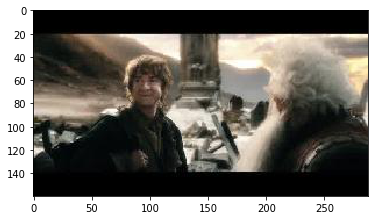

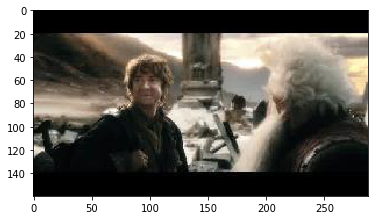

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
# Left 3D Movie Frame Preview 
hollywood_left_path = '/a/data/deep3d_data/frames2/left/33763.jpeg'
hollywood_left = np.expand_dims(np.array(Image.open(hollywood_left_path))/255.0, axis=0)
plt.imshow(hollywood_left[0])
plt.show()

# Right 3D Movie Frames Preview 
hollywood_right_path = '/a/data/deep3d_data/frames2/right/33763.jpeg'
hollywood_right = np.expand_dims(np.array(Image.open(hollywood_right_path))/255.0, axis=0)
plt.imshow(hollywood_right[0])
plt.show()

In [44]:
# Single Image Output
with tf.device("/gpu:0"): 
    
    cost_val, res, mask, up_conv, branch1, branch2, branch3, branch4, branch5 = sess.run([cost, net.prob, net.mask, net.up_conv,
                                   net.branch1_2, net.branch2_2, net.branch3_2, net.branch4_2, net.branch5_2], 
                                   feed_dict={images: hollywood_left,
                                              true_out: hollywood_right,
                                              train_mode: False})
    
print "MAE: " + str(cost_val * batchsize)

MAE: 3822.42431641


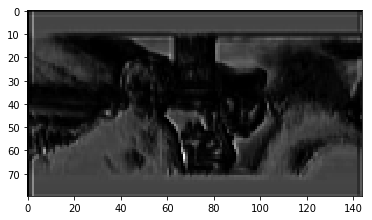

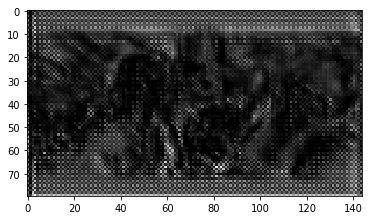

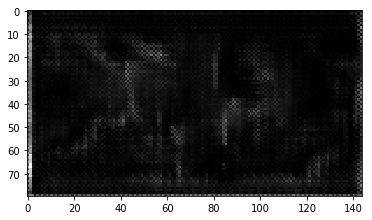

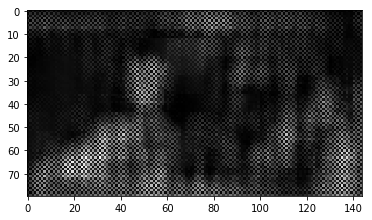

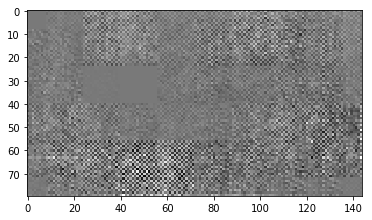

In [28]:
plt.imshow(np.mean(branch1[0],axis = 2),cmap = "gray")
plt.show()

plt.imshow(np.mean(branch2[0],axis = 2),cmap = "gray")
plt.show()

plt.imshow(np.mean(branch3[0],axis = 2),cmap = "gray")
plt.show()

plt.imshow(np.mean(branch4[0],axis = 2),cmap = "gray")
plt.show()

plt.imshow(np.mean(branch5[0],axis = 2),cmap = "gray")
plt.show()

--- Input ---


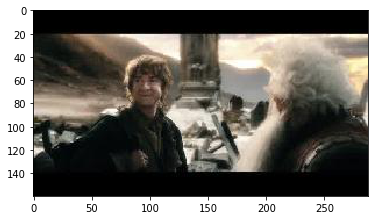

--- GT ---


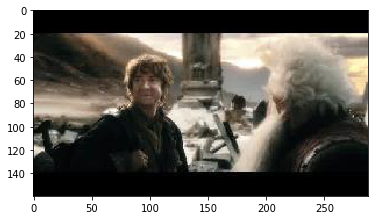

--- Our result ---


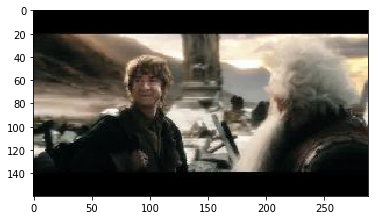

In [29]:
import matplotlib.pyplot as plt
print "--- Input ---"
plt.imshow(hollywood_left[0])
plt.show()

print "--- GT ---"
plt.imshow(hollywood_right[0])
plt.show()

print "--- Our result ---"
plt.imshow(res[0])
plt.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

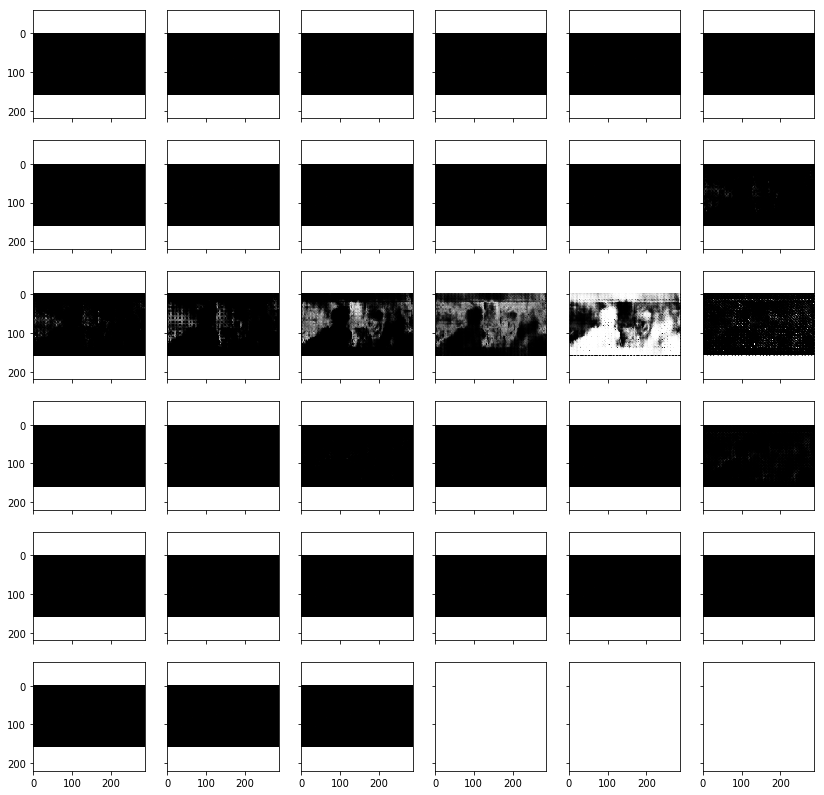

In [18]:
f, axs = plt.subplots(6, 6, sharex='col', sharey='row',figsize=(14,14))

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray",vmin=0, vmax= 1)
plt.show()

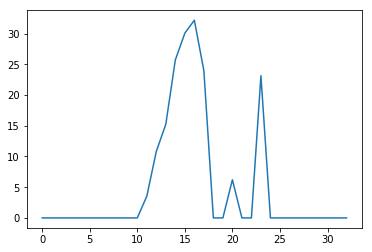

In [23]:
# Magnitude of Activation before the softmax 
channel_act_mean = np.mean(up_conv[0], axis =(0,1))
plt.plot(channel_act_mean)
plt.show()

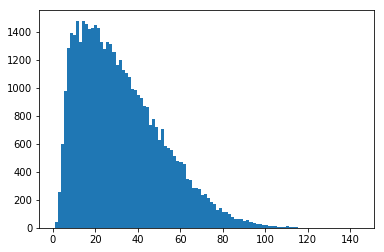

In [24]:
plt.hist(up_conv[0,:,:,16].ravel(), bins=100)
plt.show()

# MAE Calculation

In [64]:
def fetch_test_batch(): 
    num_test = len(os.listdir("/a/data/deep3d_data/frames2/left/"))
    test_batch_num = map(str, np.random.choice(range(num_test), batchsize))

    test_batch = np.empty(shape = [0, 160, 288, 3])
    test_truth = np.empty(shape = [0, 160, 288, 3])

    for i in range(batchsize):
        # Left 3D Movie Frame Preview 
        hollywood_left_path = '/a/data/deep3d_data/frames2/left/' + test_batch_num[i] + '.jpeg'
        hollywood_left = np.expand_dims(np.array(Image.open(hollywood_left_path))/255.0, axis=0)
        test_batch = np.concatenate((test_batch, hollywood_left))

        hollywood_right_path = '/a/data/deep3d_data/frames2/right/' + test_batch_num[i] + '.jpeg'
        hollywood_right = np.expand_dims(np.array(Image.open(hollywood_right_path))/255.0, axis=0)
        test_truth = np.concatenate((test_truth, hollywood_right))
    return test_batch, test_truth

In [65]:
MAE_list = []
for i in range(20):
    test_batch, test_truth = fetch_test_batch()
    cost_val, res, mask, up_conv, branch1, branch2, branch3, branch4, branch5 = sess.run([cost, net.prob, net.mask, net.up_conv,
                               net.branch1_2, net.branch2_2, net.branch3_2, net.branch4_2, net.branch5_2], 
                               feed_dict={images: test_batch,
                                          true_out: test_truth,
                                          train_mode: False})
    MAE_list.append(cost_val)

    
print "MAE: " + str(np.mean(MAE_list))

MAE: 3085.36


In [66]:
MAE_list

[3251.8525,
 3220.999,
 3044.1885,
 2835.8313,
 3043.6252,
 3432.3984,
 3167.2244,
 2990.5471,
 2680.29,
 2665.123,
 3002.4753,
 3411.4915,
 2559.1477,
 3460.4795,
 3337.1653,
 3045.3389,
 3129.1904,
 3482.6416,
 2950.8518,
 2996.3857]

In [67]:
# Per pixel MAE
np.mean(MAE_list) * 255/(160*288)

17.073945045471191